Deep Learning
=============

Assignment Sparse Autoencoder
------------

Structured from `2_fullyconnected.ipynb`

The goal of this assignment is to train a sparse autoencoder network on MNIST Data and visulize its validation data reconstruction.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import re
import sys
import pickle

import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data


In [2]:

class NoValue:
    def __init__(self):
        pass
    def __getitem__(self):
        pass
    
_no_value = NoValue()



In [3]:
def reformat(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def save_data(weights, biases, weights_filename, biases_filename, step):
    fbf = open(biases_filename + str(step) + '.pkl', 'wb')
    pickle.dump(biases, fbf)
    fbf.close()
    fwf = open(weights_filename + str(step) + '.pkl', 'wb')
    pickle.dump(weights, fwf)
    fwf.close()
    
def save_model(model, filename, step):
    with open(filename+str(step)+'.pkl', 'wb') as mf:
        pickle.dump(model, mf)

def load_model(filename):
    with open(filename, 'rb') as mf:
        model = pickle.load(mf)
    return model

First we load the MNIST data

In [4]:
data_set = input_data.read_data_sets('', False)
training_data = data_set.train
testing_data = data_set.test

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


Checking  the data

In [5]:
images_feed, labels_feed = training_data.next_batch(10000, False)
image_size = 28
num_labels = 10
np.min(images_feed)

0.0

Do validation testing:
- data as a flat matrix,


In [6]:
validation_data = data_set.validation
valid_batch, validation_labels = validation_data.next_batch(validation_data.num_examples)

In [7]:
beta = 3
rho = .1
nHidden = 196
image_size = 28
batch_size = 128

start_model = _no_value
sparse = False
batch_size, input_size, nHidden, valid_batch = (batch_size, image_size*image_size, 
                                                                         nHidden, 
                                                                         valid_batch
                                                                        )
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, input_size))
    tf_valid_dataset = tf.constant(valid_batch)
    # tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # Tied Weights Model- without tied weights 
    #                     the autoencoder can easily learn the identity given a big enough hidden layer.
    if start_model is _no_value:
        weights_hidden1 = tf.Variable(tf.truncated_normal([input_size, nHidden], stddev=0.01))
        biases_hidden1 = tf.Variable(tf.zeros([nHidden]))
        biases = tf.Variable(tf.zeros([input_size]))
    else:
        weights_hidden1 = tf.Variable(start_model[0])
        biases_hidden1 = tf.Variable(start_model[1])
        biases = tf.Variable(start_model[2])

    # Training computation.
    hidden1 = tf.nn.sigmoid(tf.matmul(tf_train_dataset, weights_hidden1) + biases_hidden1)

    output_units = tf.nn.sigmoid(tf.matmul(hidden1, tf.transpose(weights_hidden1)) + biases)

    # Sparsity computation
    if sparse == True:
        int_rho = tf.reduce_sum(hidden1, 0)
        rho_hat = tf.div(int_rho, batch_size)
        rho_hat_mean = tf.reduce_mean(rho_hat)
        rho_in = tf.sub(tf.constant(1.), rho)
        rho_hat_in = tf.sub(tf.constant(1.), rho_hat)
        klterm = tf.add(tf.mul(rho, tf.log(tf.div(rho, rho_hat))),
                        tf.mul(rho_in, tf.log(tf.div(rho_in, rho_hat_in))))
        kl_div = tf.reduce_sum(klterm)

        loss = tf.div(tf.nn.l2_loss(tf.sub(output_units, tf_train_dataset)),
                  tf.constant(float(batch_size))) + beta*kl_div
    else:
        loss = tf.div(tf.nn.l2_loss(tf.sub(output_units, tf_train_dataset)),
                  tf.constant(float(batch_size)))

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.96)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    valid_output_units = tf.nn.sigmoid(tf.matmul(
        tf.nn.sigmoid(tf.matmul(tf_valid_dataset,
                                       weights_hidden1)
                             + biases_hidden1
                             ),
        tf.transpose(weights_hidden1)) + biases)
    valid_loss = tf.div(tf.nn.l2_loss(
        tf.sub(valid_output_units, tf_valid_dataset)),
        tf.constant(float(batch_size)))

In [8]:
step = 0
verify_validation = False, 1, 1
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    batch_data, _ = training_data.next_batch(batch_size)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    v_l = 20000
    while True:
        step += 1
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # Generate a minibatch.
        batch_data, _ = training_data.next_batch(batch_size)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data}
        out = session.run(
                                                  [optimizer, loss, weights_hidden1, biases_hidden1, biases], 
                                                  feed_dict=feed_dict)
        _, l, model = out[0], out[1], out[2:]
        if step%100000 == 0:
            save_model(model, 'model', step)

        if verify_validation[0]:
            _, l, v_l, valid_out_data = session.run(
                                    [optimizer, loss, valid_loss, valid_output_units],
                                            feed_dict=feed_dict)
            print("step", step, " \tTrain loss ", l, "\tValid loss", v_l)
            if v_l < verify_validation[0]:
                    save_model(model, 'model', step)
                    print("Found better validation. Looking for better...")
                    if step < verify_validation[2]+100:
                        verify_validation = True, v_l, step
                    else:
                        verify_validation = False, v_l, step
            if step > verify_validation[2]+100:
                save_model(model, 'model', step)
                break
        else:
            if step%500 == 0:
                prev_v_l = v_l
                _, l, v_l, valid_out_data = session.run(
                                                [optimizer, loss, valid_loss, valid_output_units],
                                                feed_dict=feed_dict)
                print("step", step, " \tTrain loss ", l, "\tValid loss", v_l)
                if prev_v_l < v_l:
                    save_model(model, 'model', step)
                    print("Looking for better validation now...")
                    verify_validation = True, v_l, step

Initialized
step 500  	Train loss  6.75306 	Valid loss 246.894
step 1000  	Train loss  4.54054 	Valid loss 177.963
step 1500  	Train loss  3.60605 	Valid loss 146.044
step 2000  	Train loss  3.12995 	Valid loss 126.56
step 2500  	Train loss  3.14285 	Valid loss 113.576
step 3000  	Train loss  2.71379 	Valid loss 104.778
step 3500  	Train loss  2.40771 	Valid loss 98.5961
step 4000  	Train loss  2.15804 	Valid loss 93.843
step 4500  	Train loss  2.13532 	Valid loss 90.1316
step 5000  	Train loss  2.19076 	Valid loss 87.2048
step 5500  	Train loss  2.14627 	Valid loss 84.7848
step 6000  	Train loss  1.88396 	Valid loss 82.6281
step 6500  	Train loss  1.91025 	Valid loss 80.8797
step 7000  	Train loss  2.0091 	Valid loss 79.3597
step 7500  	Train loss  2.07123 	Valid loss 77.9696
step 8000  	Train loss  1.89105 	Valid loss 76.7654
step 8500  	Train loss  1.82525 	Valid loss 75.6853
step 9000  	Train loss  1.86371 	Valid loss 74.6953
step 9500  	Train loss  1.758 	Valid loss 73.8785
step 1

In [14]:
feature_weights, feature_biases, biases = load_model('model319101.pkl')

### Output from the Run on cluster

.
.
.
.

step 9750000    Train loss  2.56298     Valid loss 113.472

step 9750500    Train loss  2.80224     Valid loss 113.468

step 9751000    Train loss  2.59853     Valid loss 113.471
step 9751500    Train loss  2.65598     Valid loss 113.47
step 9752000    Train loss  2.50461     Valid loss 113.47
step 9752500    Train loss  2.63187     Valid loss 113.468
step 9753000    Train loss  2.84001     Valid loss 113.472
step 9753500    Train loss  2.6863      Valid loss 113.471
step 9754000    Train loss  2.73344     Valid loss 113.47
step 9754500    Train loss  2.63237     Valid loss 113.47
step 9755000    Train loss  2.52693     Valid loss 113.47
step 9755500    Train loss  2.56478     Valid loss 113.469
step 9756000    Train loss  2.50033     Valid loss 113.469
step 9756500    Train loss  2.6211      Valid loss 113.469

## Need to do the following to get the validation data
##### Because the run was done on the cluster.

In [25]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    valid_out_data = valid_output_units.eval()

Initialized


## Displaying the reconstruction of first 100 input images in validation by trained sparse autoencoder

In [16]:
if re.search("ipykernel", sys.argv[0]) :
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    print("Matplotlib is inline")
    %matplotlib inline

Matplotlib is inline


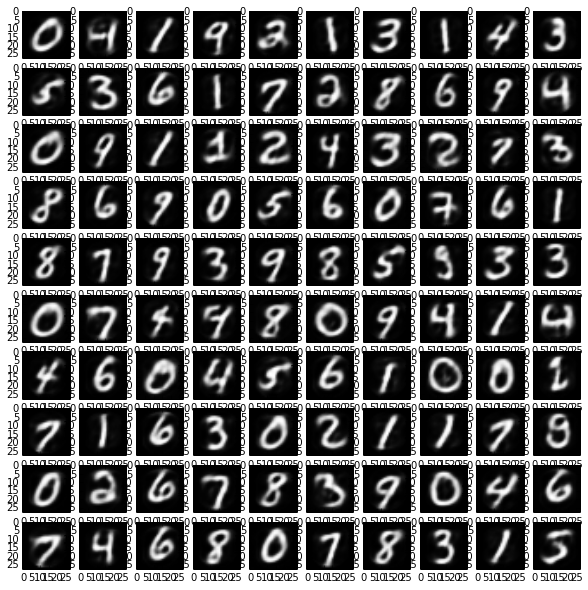

In [17]:
fig = plt.figure(figsize=(10,10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i)
    ax.imshow(valid_out_data[i].reshape(image_size, image_size), cmap=cm.gray)

### Displaying the first 100 features used to do the reconstruction

(784, 196)
(196, 784)


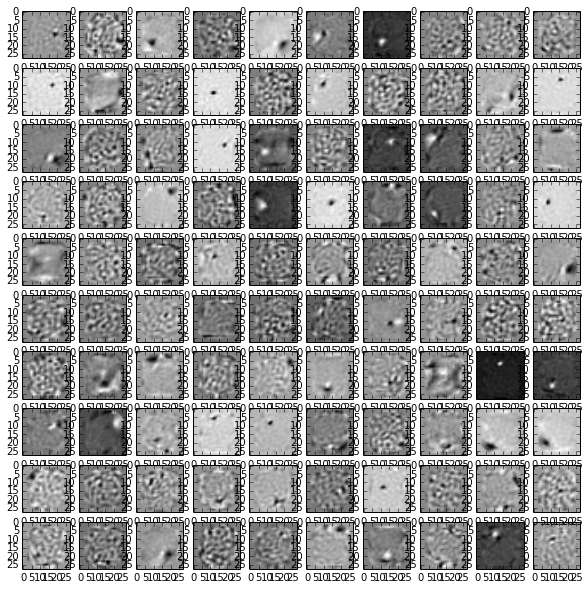

In [18]:
image_size = 28
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i)
    ax.imshow(features[i].reshape(image_size, image_size), cmap=cm.gray)

## Training Softmax Classifier

In [19]:
test_dataset, testing_labels = testing_data.next_batch(testing_data.num_examples)

In [23]:
batch_size = 128
num_labels = 10
nHidden = 196
beta = 3
rho = .1
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    weights_hidden1 = tf.constant(feature_weights)
    biases_hidden1 = tf.constant(feature_biases)
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_batch)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    logit_weights= tf.Variable(tf.truncated_normal([nHidden, num_labels]))
    logit_biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    hidden1 = tf.nn.sigmoid(tf.matmul(tf_train_dataset, weights_hidden1)  + biases_hidden1)
    logits = tf.matmul(hidden1, logit_weights) + logit_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(
      tf.nn.sigmoid(tf.matmul(tf_valid_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)
    test_prediction = tf.nn.softmax(tf.matmul(
      tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)

In [24]:
def save_for_supervised():
    return save_data(weights, biases, 'out_weights_', 'out_biases_', step)

step = 0
valid_labels = reformat(validation_labels)
valid_acc = 0
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    while True:
        step += 1
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        batch_data, labels = training_data.next_batch(batch_size)
        batch_labels = reformat(labels)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions, weights, biases = session.run([optimizer, loss, train_prediction,
                                                          logit_weights, logit_biases],
                                                         feed_dict=feed_dict)
        if step%500 == 0:
            prev_valid_acc = valid_acc
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, 
                                                          batch_labels))

            valid_acc = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % valid_acc)
            
            if prev_valid_acc > valid_acc:
                save_for_supervised()
                break
                
        if step%100000 == 0:
            save_for_supervised()
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(),
                                             test_labels))

Initialized
Minibatch loss at step 500: 8.081537
Minibatch accuracy: 11.7%
Validation accuracy: 11.4%
Minibatch loss at step 1000: 8.657642
Minibatch accuracy: 10.2%
Validation accuracy: 12.7%
Minibatch loss at step 1500: 6.035452
Minibatch accuracy: 21.1%
Validation accuracy: 14.5%
Minibatch loss at step 2000: 6.037232
Minibatch accuracy: 13.3%
Validation accuracy: 16.3%
Minibatch loss at step 2500: 5.303553
Minibatch accuracy: 19.5%
Validation accuracy: 18.3%
Minibatch loss at step 3000: 6.066236
Minibatch accuracy: 13.3%
Validation accuracy: 19.7%
Minibatch loss at step 3500: 5.152252
Minibatch accuracy: 22.7%
Validation accuracy: 20.9%
Minibatch loss at step 4000: 4.565701
Minibatch accuracy: 22.7%
Validation accuracy: 21.9%
Minibatch loss at step 4500: 4.713705
Minibatch accuracy: 25.8%
Validation accuracy: 23.4%
Minibatch loss at step 5000: 5.198499
Minibatch accuracy: 21.9%
Validation accuracy: 24.4%
Minibatch loss at step 5500: 4.767387
Minibatch accuracy: 28.1%
Validation accu

NameError: name 'test_labels' is not defined

In [20]:
valid_acc

82.76

In [27]:
prev_valid_acc

82.78

In [30]:
save_data(weights, biases, 'out_weights', 'out_biases', step)